# P P1. Regresión - Jonathan Humphreys 504065

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model  import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import pearsonr

#### 1. Se trabajará con una base de datos con información variada sobre la calidad del aire, condiciones meteorlógicas y atomsféricas en Monterrey obtenida de la Secretaría del Medio Ambiente del Estado de Nuevo León solicitadas el 24 de septiembre del 2024. Se manipularán por ahora los datos de la estación Suroeste (SE) de Guadalupe por simplicidad. Las mediciones comienzan desde el año 2021 en enero hasta el 2024 agosto. El objetivo es poder conocer el grado en el que factores individuales que logran incrementar la contaminación en la ciudad.

#### La variable de sálida será PM2.5, ya que está asociada a daños en la salud humana.

In [121]:
data = pd.read_excel("SOLICITUD_289-24_septiembre.xlsx")

In [122]:
n = data.shape[0]
col_name = data.columns.to_list()

print("Nombre de las variables: ", col_name)
print("Cantidad de varibles: ", len(col_name))
print("Cantidad de observaciones: ", n)

Nombre de las variables:  ['Fecha y hora', 'CO (ppm)', 'NO (ppb)', 'NO2 (ppb)', 'NOx (ppb) ', 'O3 (ppb)', 'PM10 (µg/m3)', 'PM2,5 (µg/m3)', 'PRS (mmHg)', 'RAINF (mm/h)', 'RH (%)', 'SO2 (ppb)', 'SR (kWh/m2)', 'Temp (°C)', 'WSR (km/h)', 'WDR (°)']
Cantidad de varibles:  16
Cantidad de observaciones:  32133


#### 2. El conjunto de datos recolectado, presenta varios huecos en información, lo cual se demostrará más abajo con el código proporcionado. 

In [123]:
columns_with_nan = data.columns[data.isna().any()].tolist()
print("Columnas con valores NaN:", columns_with_nan)
print("Νúmero de columnas con valores NaN:", len(columns_with_nan))

Columnas con valores NaN: ['CO (ppm)', 'NO (ppb)', 'NO2 (ppb)', 'NOx (ppb) ', 'O3 (ppb)', 'PM10 (µg/m3)', 'PM2,5 (µg/m3)', 'PRS (mmHg)', 'RAINF (mm/h)', 'RH (%)', 'SO2 (ppb)', 'SR (kWh/m2)', 'Temp (°C)', 'WSR (km/h)', 'WDR (°)']
Νúmero de columnas con valores NaN: 15


#### Cómo se puede observar, la mayoría de las columnas presentan una falta de información por lo que hay que eliminar aquellas columnas cuya información sea excesiva. Para ello, se hará un cálculo para identificar aquellas columnas que tiene un 30% o más de información faltante, después, se eliminarán, mientras que el resto se utilizará la media para no afectar al análisis posterior.

In [124]:
nan_percentage = data.isna().mean() * 100
print(nan_percentage)

Fecha y hora      0.000000
CO (ppm)          2.125541
NO (ppb)         10.945134
NO2 (ppb)         7.459621
NOx (ppb)         7.459621
O3 (ppb)          3.522858
PM10 (µg/m3)      3.196091
PM2,5 (µg/m3)    14.710734
PRS (mmHg)        3.354807
RAINF (mm/h)      1.503128
RH (%)            1.817446
SO2 (ppb)         5.113124
SR (kWh/m2)       0.441913
Temp (°C)         9.034326
WSR (km/h)        1.484455
WDR (°)           7.721034
dtype: float64


#### Por lo pronto no hay columnas que tengan una cantidad considerable de datos faltantes, por lo que se optará unicamente por llenar con la media en cada columna respectiva.

In [125]:
data_filled = data.apply(lambda x: x.fillna(x.mean()), axis=0)
nan_percentage = data_filled.isna().mean() * 100
print(nan_percentage)

Fecha y hora     0.0
CO (ppm)         0.0
NO (ppb)         0.0
NO2 (ppb)        0.0
NOx (ppb)        0.0
O3 (ppb)         0.0
PM10 (µg/m3)     0.0
PM2,5 (µg/m3)    0.0
PRS (mmHg)       0.0
RAINF (mm/h)     0.0
RH (%)           0.0
SO2 (ppb)        0.0
SR (kWh/m2)      0.0
Temp (°C)        0.0
WSR (km/h)       0.0
WDR (°)          0.0
dtype: float64


#### Después, se separará la columna fecha y hora en dos. La dos variables se pasarán a una escala numérica, se medirán el número de días desde el comienzo del año para la fecha, y el número de minutos que han pasado desde la media noche.

In [126]:
data_filled['Fecha y hora'] = pd.to_datetime(data_filled['Fecha y hora'], format='%m/%d/%Y %I:%M:%S %p')

data_filled['Fecha'] = data_filled['Fecha y hora'].dt.date
data_filled['Hora'] = data_filled['Fecha y hora'].dt.time

reference_date = pd.to_datetime('2021-01-01')
data_filled['Fecha'] = (pd.to_datetime(data_filled['Fecha']) - reference_date).dt.days

# Convertir la columna 'Hora' en una variable cuantitativa (número de minutos desde la medianoche)
data_filled['Hora'] = data_filled['Fecha y hora'].dt.hour * 60 + data_filled['Fecha y hora'].dt.minute

# Eliminar la columna original 'Fecha y hora'
data_filled = data_filled.drop(columns=['Fecha y hora'])

In [127]:
print(data_filled["Fecha"].head())

0    0
1    0
2    0
3    0
4    0
Name: Fecha, dtype: int64


#### A continuación, se hará una revisión de la colinealidad que hay entre las variables presentes mediante una matriz de correlación, dependiendo de los resultados, se optará por no trabajar con alguna de las variables.

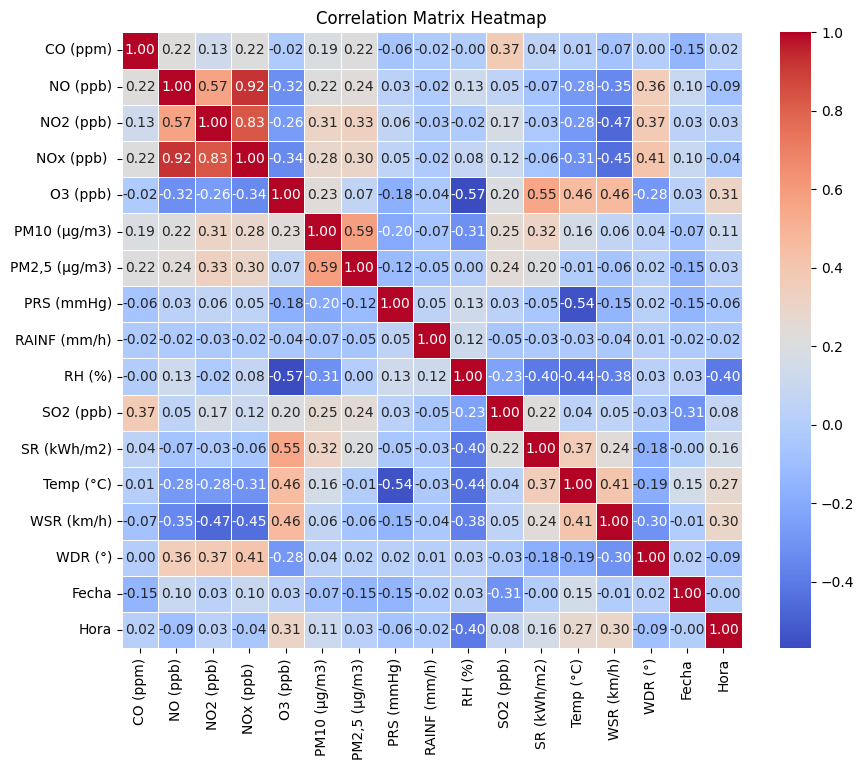

Variables que pudieran ser removidas por colinealidad alta: {'NO2 (ppb)', 'NO (ppb)', 'NOx (ppb) '}


In [128]:
corr_matrix = data_filled.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()
high_corr_vars = set()
threshold = 0.8

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if(corr_matrix.iloc[i, j]>threshold):
            high_corr_vars.add(corr_matrix.columns[j])
            high_corr_vars.add(corr_matrix.columns[i])
        
# Print analysis
if high_corr_vars:
    print(f"Variables que pudieran ser removidas por colinealidad alta: {high_corr_vars}")
else:
    print("Ninguna variable debe ser removida.")

#### Los resultados anteriores sugieren que hay un nivel alto de colinealidad entre NO y NOx, así como NOx y NO2. De acuerdo con CATC (1999), NOx es una familia de compuestos químicos, a la cual pertenecen NO2 y NO. Usualmente cuando se incluyen en un conjunto de datos, es debido a que se mide la mezcla de varios componentes de su familia. No obstante, para un modelo de regresión será pertinente su retiro para tener certeza en la contribución individual de cada variable.

#### Por otro lado, la alta colinearidad entre NO2 y NO pudiera ser debido a que NO puede ser oxidado a NO2 con la suficiente presencia de oxígeno y rayos ultravioleta. Según Krzyzanowski, M. (2023), ΝΟ2 es un componente que está principalmente relacionado con PM2.5 debido a su participación en la formación de partículas secundarias como nitratos. Por lo tanto, se elige NO2 sobre NO ya que se espera a que tenga una mayor poder predictivo.

In [129]:
data_filled = data_filled.drop(columns=['NO (ppb)', 'NOx (ppb) '])

#### Finalmente, se utilizará el método de Tukey para revisar la presencia de datos atípicos en el conjunto de datos, y evaluar si tiene sentido su inclusión en los modelos de regresión con los que se trabajarán.

In [130]:
def tukey_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_b = Q1 - 1.5 * IQR
    upper_b = Q3 + 1.5 * IQR
    return lower_b, upper_b

for column in data_filled.columns:
    if data_filled[column].dtype in ['int64', 'float64']:
        lower_b, upper_b = tukey_outliers(data_filled[column])
        print(f"Columna: {column}")
        print(f"Limite inferior: {lower_b}")
        print(f"Limite superior: {upper_b}\n")
        
        # Identify outliers
        outliers = data_filled[(data_filled[column] < lower_b) | (data_filled[column] > upper_b)]
        print(f"Outliers en columna: {column}:\n", outliers[column], "\n")

Columna: CO (ppm)
Limite inferior: -1.0550000000000002
Limite superior: 4.025

Outliers en columna: CO (ppm):
 132      32.00
384       4.12
385       4.18
386       4.10
442       4.16
443       4.17
491       4.09
492       4.28
493       4.14
494       4.07
495       4.59
496       4.09
506       4.04
507       4.25
510       4.07
585       4.18
586       4.06
802       4.03
1451     12.00
6174      4.17
6176      4.06
6225      4.09
6249      4.18
6491      4.31
9333      4.44
26814     4.45
29705    37.00
Name: CO (ppm), dtype: float64 

Columna: NO2 (ppb)
Limite inferior: -9.849999999999998
Limite superior: 32.949999999999996

Outliers en columna: NO2 (ppb):
 1498     36.0
1499     33.4
1855     34.9
1856     37.2
1978     40.3
         ... 
30814    33.4
30823    36.2
31879    38.1
31902    34.1
32095    33.6
Name: NO2 (ppb), Length: 1523, dtype: float64 

Columna: O3 (ppb)
Limite inferior: -19.5
Limite superior: 72.5

Outliers en columna: O3 (ppb):
 807      79.0
808      77.0


#### Los datos anteriores muestran los valores atípicos en cada columna, la mayoría tienen valores que pueden ser plausibles con excepción de CO (ppm), el cual cuenta con algunos valores de 31 y 37, los cuales están cerca de acuerdo con NIOSH y NAAQS de causar simptomas después de 6 u 8 horas de exposición en las personas. Mirando el conjunto de datos para los días en los que 31 y 37 ocurrieron, fueron picos muy repentinos en comparación con los registros de horas después y antes, además, no hay suficiente información para poder justificar sus mediciones, por lo que sería probable que se tratase de un error. Por lo tanto, estos serán retirados y lo demás se mantienen.

In [131]:
data_filled = data_filled[data_filled['CO (ppm)'] <= 30]

#### 3. La selección de características se hará con el método de selección hacia atrás ya que se supone que la mayoría de las variables que se tienen del conjunto de datos pueden ser relevantes, y a través de esta técnica podemos considerarlas desde el principio. Se retiran la columnas PM2,5 del conjunto X y se considera como Y.

In [132]:
X = data_filled.drop(columns=['PM2,5 (µg/m3)'])
y = data_filled['PM2,5 (µg/m3)']

def backward_selection(X, y):
    features = X.columns.tolist()
    while len(features) > 0:
        model = sm.OLS(y, sm.add_constant(X[features])).fit()
        p_values = model.pvalues.iloc[1:]  # Excluir el p-valor del intercepto
        max_p_value = p_values.max()
        if max_p_value >= 0.05:  # Umbral de significancia
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features

# Aplicar selección hacia atrás
selected_features_backward = backward_selection(X, y)
print("Características elegidas (selección hacia atrás):", selected_features_backward)
print("Cantidad de características elegidas:", len(selected_features_backward))

Características elegidas (selección hacia atrás): ['CO (ppm)', 'NO2 (ppb)', 'O3 (ppb)', 'PM10 (µg/m3)', 'PRS (mmHg)', 'RAINF (mm/h)', 'RH (%)', 'SO2 (ppb)', 'SR (kWh/m2)', 'Temp (°C)', 'WSR (km/h)', 'WDR (°)', 'Fecha', 'Hora']
Cantidad de características elegidas: 14


#### 4. Para el análisis de predicción, se utilizará como modelo lineal una regresión múltiple lineal ya que se cuentan con múltiples variables y una sola variable de sálida, en este caso PM2,5. Se dividará el conjunto de datos en entrenamiento y de prueba en 80/20 para poder obtener métricas sobre la variabilidad (R<sup>2</sup>) y el grado de error (RMSE).

In [153]:
X_train, X_test, Y_train, Y_test = train_test_split(X[selected_features_backward], y, test_size=0.2, random_state=0)

model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred_linear = model.predict(X_test)

r2_linear = r2_score(Y_test, Y_pred_linear)
RMSE_linear = np.sqrt(np.sum((Y_test - Y_pred_linear) ** 2) / X_test.shape[0])
print("R^2:", r2_linear)
print("RMSE:", RMSE_linear)

X_train_const = sm.add_constant(X_train)
model_ols = sm.OLS(Y_train, X_train_const).fit()
print(model_ols.summary())
print("Valores-p del modelo: \n", model_ols.pvalues)

R^2: 0.4511492081766245
RMSE: 7.703337904555768
                            OLS Regression Results                            
Dep. Variable:          PM2,5 (µg/m3)   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     1481.
Date:                Fri, 21 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:59:56   Log-Likelihood:                -88327.
No. Observations:               25704   AIC:                         1.767e+05
Df Residuals:                   25689   BIC:                         1.768e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------


#### A través de los datos anteriores, podemos notar que casi todos los coeficientes cumplen con la condición p < 0.5, por lo que se sugiere que hay una asociación estadísticamente significativa con la variable dependiente con excepción de la temperatura con un valor de 0.052, además que su valor t no pasa del valor crítico esperado, por lo que su retiro del modelo será la mejor opción.

#### A continuación se utilizará un modelo KNN para aumentar la certitud en la predicción de nuestro modelo ya que posiblemente PM2,5 no adopte una relación lineal con los predictores totalmente. Se utilizará el mismo conjunto de datos separados que en el anterior modelo. Primeramente, se calculará el número de vecinos adecuado utilizando la función GridSearchCV() el cual encuentra la mejor opción que minimize el error de predicción. Después se calcularán las mismas métricas (R<sup>2</sup> y RMSE) para una comparación posterior.

In [134]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
param_grid = {'n_neighbors': np.arange(1, 31)}
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, Y_train)
best_k = knn_cv.best_params_['n_neighbors']
print(f'Mejor número de vecinos (k): {best_k}')

Mejor número de vecinos (k): 7


In [154]:
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(X_train, Y_train)
Y_pred_knn = knn.predict(X_test)

r2_knn = r2_score(Y_test, Y_pred_knn)
RMSE_knn = np.sqrt(np.sum((Y_test - Y_pred_knn) ** 2) / X_test.shape[0] ) # In here, it doesn't make sense to use RSE, since KNN doesn't have predictors.
print("R^2:", r2_knn)
print("RMSE:", RMSE_knn)


R^2: 0.5413190083184426
RMSE: 7.042180823138001


In [151]:
RMSE_diff = RMSE_linear-RMSE_knn
print("RMSE diff: ",RMSE_diff)

r2_diff = r2_knn-r2_linear
print("r2 diff: ",r2_diff)

RMSE diff:  0.661157081417767
r2 diff:  0.09016980014181808


#### A través de R<sup>2</sup> podemos determinar que el modelo KNN puede explicar ligeramente mejor la variabilidad y cuenta ligeramente con menos grado de error que un modelo de regresión múltiple linear.

#### 5. Se demuestra la métrica RMSE de cada modelo para saber el promedio de error que hay en las predicciones de cada modelo, así como el coeficiente de Pearson (r) y una respectiva gráfica para conocer la diferencia entre predicción y valores reales de los modelos obtenidos hasta ahora. 

Correlación Pearson: 0.6726281071358259, p-value: 0.0
RMSE:  7.703337904555768


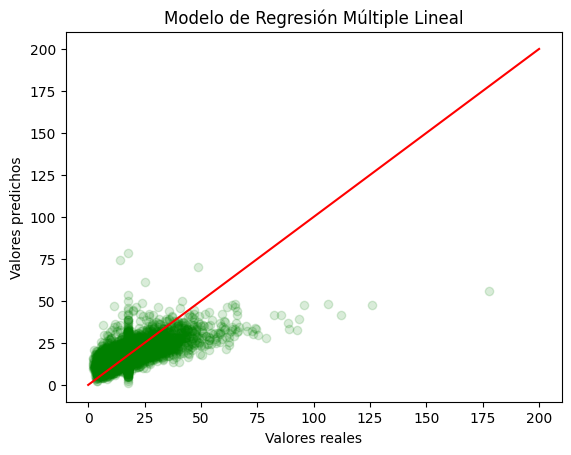

Correlación Pearson: 0.7393555651451836, p-value: 0.0
RMSE:  7.042180823138001


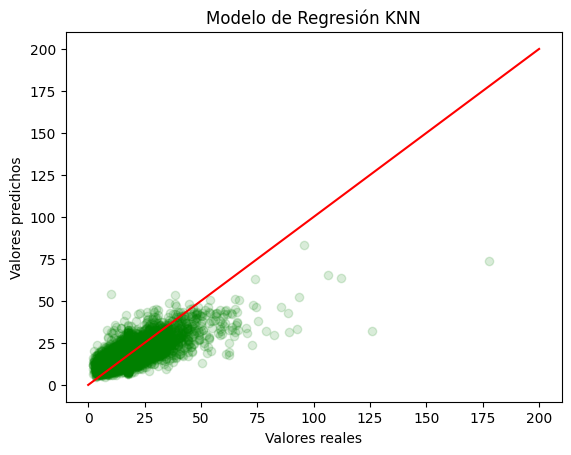

In [156]:
# MULTIPLE LINEAR REGRESSION

r_pearson_linear, p_value_pearson_linear = pearsonr(Y_test, Y_pred_linear)
print(f"Correlación Pearson: {r_pearson_linear}, p-value: {p_value_pearson_linear}")
print("RMSE: ", RMSE_linear)

x_line = np.linspace(0, 200, 180)
y_line = x_line  # Since it's a 45-degree line, y = x

plt.scatter(Y_test, Y_pred_linear, color='green',alpha=0.150)
plt.plot(x_line,y_line, color='red', label="Linea de 45 grados")
plt.title('Modelo de Regresión Múltiple Lineal')
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos') 
plt.show() 

# KNN REGRESSION

r_pearson_knn, p_value_pearson_knn = pearsonr(Y_test, Y_pred_knn)
print(f"Correlación Pearson: {r_pearson_knn}, p-value: {p_value_pearson_knn}")
print("RMSE: ", RMSE_knn)

plt.scatter(Y_test, Y_pred_knn, color='green', alpha=0.150)
plt.plot(x_line,y_line, color='red', label="Linea de 45 grados")
plt.title('Modelo de Regresión KNN')
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.show()

#### A través de la información anterior se puede determinar que el modelo KNN tiene una relación lineal entre los valores predecidos y los reales más fuerte que el modelo de regresión lineal múltiple a través del coeficiente de Pearson (0.73 > 0.67), lo cual indica que KNN interpola los valores con mayor precisión que el otro modelo. Igualmente, su RMSE es ligeramente mejor, por lo que el error promedio de las predicciones es más bajo en comparación. 

#### En conclusión, el modelo KNN demuestra ser más efectivo en términos de precisión y ajuste a los datos en comparación con el modelo de regresión lineal múltiple. Esto se refleja en su mayor R² y menor RMSE, lo que sugiere que KNN es una mejor opción para predecir la variable de interés en este caso.

#### 6. En este punto, se realizará un análisis de inferencia, por medio de un modelo de regresión múltiple lineal como en la sección anterior. No obstante, se tendrá que descartar la columna de temperatura para proceder ya que no se puede garantizar que rechace la hipótesis nula como se espera.

In [257]:
# Eliminar la columna 'Temp (°C)' de los conjuntos de datos de entrenamiento y prueba
X_train_linear = X_train.drop(columns=['Temp (°C)'])
X_test_linear = X_test.drop(columns=['Temp (°C)'])

# Ajustar el modelo de regresión lineal múltiple
model = LinearRegression()
model.fit(X_train_linear, Y_train)
Y_pred_linear = model.predict(X_test_linear)

# Calcular el R-squared y el RMSE para el modelo de regresión lineal múltiple
r2_linear = r2_score(Y_test, Y_pred_linear)
RMSE_linear = np.sqrt(np.sum((Y_test - Y_pred_linear) ** 2) / X_test_linear.shape[0])
print("R^2:", r2_linear)
print("RMSE:", RMSE_linear)

# Ajustar el modelo OLS con statsmodels utilizando los datos de entrenamiento
X_train_linear_const = sm.add_constant(X_train_linear)
model_ols = sm.OLS(Y_train, X_train_linear_const).fit()

# Mostrar el resumen del modelo OLS
print(model_ols.summary())
print("Valores-p del modelo: \n", model_ols.pvalues)

R^2: 0.4507253937981974
RMSE: 7.706311531817554
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     1594.
Date:                Fri, 21 Feb 2025   Prob (F-statistic):               0.00
Time:                        20:08:50   Log-Likelihood:                -88328.
No. Observations:               25704   AIC:                         1.767e+05
Df Residuals:                   25690   BIC:                         1.768e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------


#### Con los resultados del modelo, podemos notar que los coeficientes del modelo indican que CO, NO, NO2, O3, PM10, RH, SO2 y Hora tienen una relación positiva con PM10, y que PRS, RAINF, WDR y Fecha tienen una relación negativa con los valores predichos por el modelo. El coeficiente que tiene el mayor impacto, aumentando el PM2,5 por unidad un 4.9967 en el modelo es SR (kWh/m2), el cual representa la radiación solar recibida por metro cuadrado, medida en kilovatios-hora, esto lo hace con un intervalo de confianza de entre 4.360 y 5.633.

#### Investigando la causa con información externa, se puede corroborar que la radiación solar es responsable de la producción de sustancias tóxicas dado a la acumulación de contaminantes en la atmósfera, debido a reacciones fotoquímicas. Además, altas cantidades de radiación solar podrían provocar inversión térmica que atrape contaminantes en el suelo, no permitiendoles disperarse y aumentando sus concentraciones, según Xinshuo, Z.(2022) y European Environment Agency (2020).

#### Por otro lado, KNN no será utilizado por su difícil interpretabiliad, por lo que se optará usar un modelo de de regresión polinomial cuadrática, ya que pareciera que a medida que los valores reales aumentan, los valores predichos tienden a reducirse, por lo que un modelo cuadrático quizá mejore la variabilidad y con ello la precisión. Se transformarán las variables predictoras originales en características polinómicas de grado 2, incluyendo términos cuadráticos y de interacción. Para evitar el sobreajuste y seleccionar las características más relevantes, se aplicará la regularización LASSO. Se evaluará el rendimiento del modelo utilizando métricas como el error cuadrático medio (MSE).

In [ ]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

X_train_linear = X_train.drop(columns=['Temp (°C)'])
X_test_linear = X_test.drop(columns=['Temp (°C)'])

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_linear)
X_test_poly = poly.transform(X_test_linear)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_linear)
X_test_poly = poly.transform(X_train_linear) 

feature_names = poly.get_feature_names_out(input_features=X_train_linear.columns)

X_train_poly_df = pd.DataFrame(X_train_poly, columns=feature_names)
X_test_poly_df = pd.DataFrame(X_test_poly, columns=feature_names)

lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_poly_df, Y_train)
optimal_alpha = lasso_cv.alpha_

print(f"Alpha óptimo: {optimal_alpha}")

lasso = Lasso(alpha=optimal_alpha, random_state=42)
lasso.fit(X_train_poly_df, Y_train)

selected_features = feature_names[lasso.coef_ != 0]

X_train_selected = X_train_poly_df[selected_features]

X_train_selected_sm = sm.add_constant(X_train_selected)

model_sm_selected = sm.OLS(Y_train, X_train_selected_sm).fit()

print(model_sm_selected.summary())

y_pred = lasso.predict(X_test_poly_df)
mse = mean_squared_error(Y_train, y_pred) 
print(f"MSE: {mse}")

coefficients = pd.Series(lasso.coef_, index=feature_names)
print("LASSO coeficients:")
print(coefficients)

print(f"Intercepto: {lasso.intercept_}")

Alpha óptimo: 608.203380520165
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     1476.
Date:                Sat, 22 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:09:55   Log-Likelihood:                -85427.
No. Observations:               25704   AIC:                         1.709e+05
Df Residuals:                   25681   BIC:                         1.711e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

#### De acuerdo con los resultados del modelo de regresión lineal con regularización LASSO, las variables que tienen una relación positiva con el predictor (PM2.5) son NO2 (ppb) PRS (mmHg), O3 (ppb) PRS (mmHg), O3 (ppb) Fecha, PM10 (µg/m3) PRS (mmHg), PM10 (µg/m3) RH (%), PRS (mmHg) SO2 (ppb), PRS (mmHg) WDR (°), PRS (mmHg) Fecha, PRS (mmHg) Hora, RH (%) WDR (°), Fecha^2. Por otro lado, las variables que tienen una relación negativa con el predictor son PM10 (µg/m3)^2, PM10 (µg/m3) Fecha, PRS (mmHg)^2, WDR (°)^2, Fecha Hora, Hora^2. Finalmente, las variables que no deberán ser consideradas debido a que tienen un p-value mayor o igual a 0.05 son NO2 (ppb) Hora, O3 (ppb) Hora, PM10 (µg/m3) Hora, PRS (mmHg) RH (%), WDR (°) Hora.

#### De acuerdo con los resultados del modelo de regresión lineal con regularización LASSO, se encontró que las siguientes variables tienen un impacto significativo en la variable dependiente (PM2.5):

- #### PM10 (µg/m3) Fecha: Un aumento de una unidad en esta variable se asocia con una disminución de 0.0002 unidades en PM2.5, con un intervalo de confianza del 95% de [-0.0002, -0.0002], muy cerrado.
- #### PM10 (µg/m3) RH (%): Un aumento de una unidad en esta variable se asocia con un aumento de 0.0026 unidades en PM2.5, con un intervalo de confianza del 95% de [0.002, 0.003].
- #### PM10 (µg/m3) PRS (mmHg): Un aumento de una unidad en esta variable se asocia con un aumento de 0.0002 unidades en PM2.5, con un intervalo de confianza del 95% de [0.000, 0.000], muy cerrado.

#### Estas tres variables son las que tienen los coeficientes más grandes en valor absoluto, lo que indica que son las que tienen el mayor impacto en PM2.5. Sin embargo, es importante tener en cuenta que hay más variables incluidas en el modelo tienen un impacto significativo en PM2.5. El modelo tiene un R-cuadrado de 0.558, lo que indica que explica el 55.8% de la variabilidad en la variable dependiente.

#### Los resultados pueden ser justificados con información externa, de acuerdo con EPA (2016), PM10 pueden incluir partículas más grandes que, a través de procesos físicos, se fragmentan en partículas más pequeñas PM2.5. Por otro lado, la humedad relativa puede afectar la forma en que las partículas se comportan en el aire. Por ejemplo, la humedad puede hacer que las partículas absorban agua y aumenten de tamaño, lo que puede influir en su concentración. Además, la presión atmosférica puede influir en la dispersión de los contaminantes. Las áreas de alta presión tienden a tener condiciones más estables, lo que puede llevar a la acumulación de contaminantes.




#### En conclusión podido notar que un modelo de regresión de vecinos más cercanos (KNN) tiene una mayor precisión que un modelo de regresión lineal cuando se busca predecir los niveles de PM2.5 dadas las condiciones meteorológicas y la concentración de otros contaminantes. Esto se puede deber a que el PM2.5 no presenta una relación lineal con las demás variables. Por otro lado, se ha podido demostrar que la radiación solar (SR) bajo un modelo lineal es la variable que tiene un mayor impacto en los niveles de PM2.5, lo cual tiene sentido dado a que la radiación solar es un factor en la creación de aerosoles secundarios. Además, altas cantidades de radiación solar podría provocar inversión térmica, lo cual no permite a los contaminantes disperarse.

#### Finalmente, se ha podido demostrar que las variables PM10 (µg/m3) Fecha, PM10 (µg/m3) RH (%), PM10 (µg/m3) PRS (mmHg) también tienen un mayor impacto en PM2.5 bajo un modelo cuadrático, lo cual también tiene sentido dado a que PM10 y PM2.5 están altamente correlacionadas, además que la humedad relativa y la presión atmosférica son factores que influyen en la forma en que las partículas se comportan en el aire.

#### <b>Referencias bibliográficas:</b>
- Agencia de Protección Ambiental de Estados Unidos (EPA). (2016). Particulate Matter (PM) Basics. https://www.epa.gov/pm-pollution/particulate-matter-pm-basics

- CATC (1999). Universidad Nacional de La Plata. Recuperado de https://1library.co/document/qmrj82wy-universidad-nacional-de-la-plata.html

- European Environment Agency. (n.d.). Temperature inversion traps pollution at ground level. Recuperado de https://www.eea.europa.eu/en/analysis/maps-and-charts/temperature-inversion-traps-pollution-at?size=n_10_n&filters%5B0%5D%5Bfield%5D=objectProvides&filters%5B0%5D%5Btype%5D=any&filters%5B0%5D%5Bvalues%5D%5B0%5D=Chart%20%28interactive%29&filters%5B0%5D%5Bvalues%5D%5B1%5D=Dashboard&filters%5B0%5D%5Bvalues%5D%5B2%5D=Figure%20%28chart%2Fmap%29&filters%5B0%5D%5Bvalues%5D%5B3%5D=Infographic&filters%5B0%5D%5Bvalues%5D%5B4%5D=Map%20%28interactive%29&filters%5B1%5D%5Bfield%5D=readingTime&filters%5B1%5D%5Btype%5D=any&filters%5B1%5D%5Bvalues%5D%5B0%5D%5Bname%5D=All&filters%5B1%5D%5Bvalues%5D%5B0%5D%5BrangeType%5D=fixed&filters%5B2%5D%5Bfield%5D=issued.date&filters%5B2%5D%5Btype%5D=any&filters%5B2%5D%5Bvalues%5D%5B0%5D=Last%205%20years&filters%5B3%5D%5Bfield%5D=language&filters%5B3%5D%5Btype%5D=any&filters%5B3%5D%5Bvalues%5D%5B0%5D=en

- National Center for Biotechnology Information. (2022). Air pollution particles can reduce the ability of the immune system to fight infections. Recuperado de https://pmc.ncbi.nlm.nih.gov/articles/PMC9015163/#:~:text=Air%20pollution%20particles%20can%20reduce,occur%20to%20produce%20toxic%20substances.

- Krzyzanowski, M. (2023, junio). NO2 briefing. Recuperado de https://www.env-health.org/wp-content/uploads/2023/06/NO2_briefing_EN.pdf

#### <b>Código de honor:</b> Doy mi palabra de que he realizado esta actividad con integridad académica.